# IPCV Assignment 1

Authors:

- Mauro Dore             - mauro.dore@studio.unibo.it            -
- Gian Mario Marongiu    - gianmario.marongiu@studio.unibo.it    - 0001092260
- Riccardo Murgia        - riccardo.murgia2@studio.unibo.it      - 0001083930

## Imports and Auxiliary Functions

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


In [14]:
def show_multiple_images(image_list, cols=3, titles=None, global_title=None, plot_height=3):
    if not image_list:
        raise ValueError("The image list must not be empty.")

    num_images = len(image_list)
    
    if titles and len(titles) != num_images:
        raise ValueError("Titles list length must match the number of images.")
    
    rows = -(-num_images // cols)  # Equivalent to math.ceil

    fig, axes = plt.subplots(rows, cols, figsize=(10, plot_height * rows))
    fig.subplots_adjust(top=0.9 if global_title else 1.0)
    
    if global_title:
        fig.suptitle(global_title, fontsize=16, fontweight='bold')
    
    axes = axes.flatten() if num_images > 1 else [axes]
    
    for i, ax in enumerate(axes):
        if i < num_images:
            ax.imshow(cv2.cvtColor(image_list[i], cv2.COLOR_BGR2RGB))
            ax.set_axis_off()
            if titles:
                ax.set_title(titles[i], fontsize=12, fontweight='bold')
        else:
            ax.set_visible(False)
    
    plt.tight_layout()
    plt.show()

    
def png_to_numpy(path, list):
    for image_name in os.listdir(path):
        image_path = os.path.join(path, image_name)
        image = cv2.imread(image_path)
        list.append(image)

def object_retrieve(model, scene, min_match_count=50, ratio_thresh=0.7, flann_trees=8, flann_checks=50):
    sift = cv2.SIFT_create()
    
    # Detect keypoints and compute descriptors
    kp_query, des_query = sift.detectAndCompute(model, None)
    kp_train, des_train = sift.detectAndCompute(scene, None)

    # FLANN parameters for matching
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=flann_trees)
    search_params = dict(checks=flann_checks)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    # Match descriptors using k-NN (k=2)
    matches = flann.knnMatch(des_query, des_train, k=2)
    
    # Lowe's ratio test to select good matches. m is first match, n is second match.
    good_matches = []
    for m, n in matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)
    
    if len(good_matches) > min_match_count:
        # Extract points from the good matches
        src_pts = np.float32([kp_query[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp_train[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        
        # Find homography matrix
        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        
        # Get the bounding box around the query image in the train image
        height, width = model.shape[:2]
        img_corners = np.float32([[0, 0], [0, height - 1], [width - 1, height - 1], [width - 1, 0]]).reshape(-1, 1, 2)
        dst = cv2.perspectiveTransform(img_corners, H)

        # Draw bounding box on the train image
        img_train_boxed = cv2.polylines(np.array(scene), [np.int32(dst)], True, (0, 255, 0), 5, cv2.LINE_AA)
        
        return True, img_train_boxed, len(good_matches)
    else:
        return False, scene, len(good_matches)


def print_detection_summary(real_matchings, detected_matchings):
    print("Detection summary:")
    for scene in real_matchings.keys():
        scene_str = f"Scene {scene}".ljust(20)
        present_models_str = f"Models in the image: {real_matchings[scene]}".ljust(60)
        detected_models_str = f"Models detected: {detected_matchings[scene]}"
    
        print(f"{scene_str} {present_models_str} {detected_models_str}")


In [3]:
MODELS_SINGLE_INSTANCE_PATH = "models_single_instance"
SCENES_SINGLE_INSTANCE_PATH = "scenes_single_instance"
MODELS_MULTIPLE_INSTANCES_PATH = "models_multiple_instances"
SCENES_MULTIPLE_INSTANCES_PATH = "scenes_multiple_instances"

models_single_instance = []
scenes_single_instance = []
models_multiple_instances = []
scenes_multiple_instances = []

png_to_numpy(MODELS_SINGLE_INSTANCE_PATH, models_single_instance)
png_to_numpy(SCENES_SINGLE_INSTANCE_PATH, scenes_single_instance)
png_to_numpy(MODELS_MULTIPLE_INSTANCES_PATH, models_multiple_instances)
png_to_numpy(SCENES_MULTIPLE_INSTANCES_PATH, scenes_multiple_instances)
    
print(f"{len(models_single_instance)} models and {len(scenes_single_instance)} scenes for single instance detection task")
print(f"{len(models_multiple_instances)} models and {len(scenes_multiple_instances)} scenes for multiple instances detection task")


14 models and 5 scenes for single instance detection task
12 models and 7 scenes for multiple instances detection task


## Task Analysis

The objective is to perform instance detection using the provided model images. Several challenges must be addressed:

- The scenes contain significant noise, which must be mitigated prior to detection;
- The models are noticeably brighter than the scenes, indicating the need for a method that is robust to intensity variations;
- The models and scenes exhibit considerable variation in shape, necessitating the use of a scale-invariant detector.

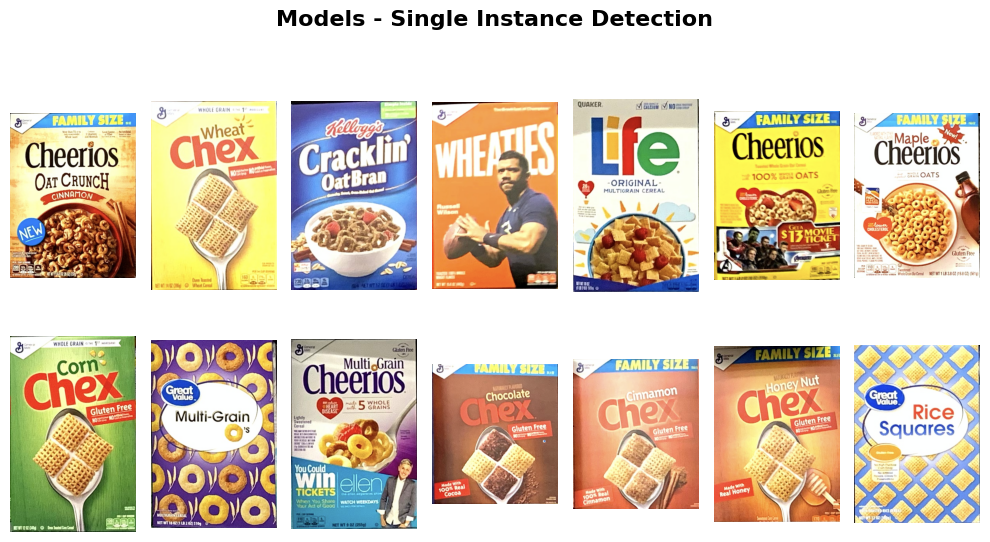

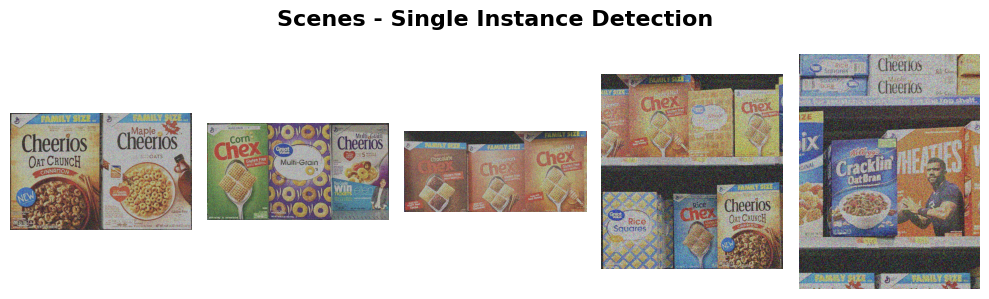

In [4]:
single_instance_real_matchings = {0: [0, 6], 1: [7, 8, 9], 2: [10, 11, 12], 3: [11, 12, 13, 1, 0], 4: [2, 3]}
show_multiple_images(models_single_instance, cols=7, global_title="Models - Single Instance Detection")
show_multiple_images(scenes_single_instance, cols=5, global_title="Scenes - Single Instance Detection")


## Scenes Denoising

Single Detection Scenes Denoising: 100%|██████████| 5/5 [00:00<00:00,  7.99it/s]


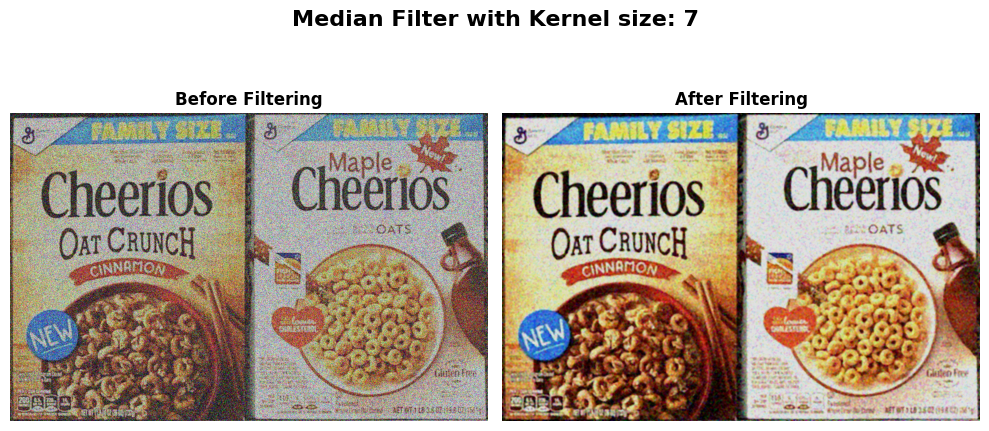

In [5]:
denoised_scenes_single_instance = []
denoised_scenes_multiple_instances = []
kernel_size = 7

for scene in tqdm(scenes_single_instance, desc="Single Detection Scenes Denoising: "):
    denoised_scene = cv2.medianBlur(scene, kernel_size)
    #denoised_scene = cv2.bilateralFilter(scene, d=9, sigmaColor=50, sigmaSpace=200)
    #denoised_scene = cv2.fastNlMeansDenoisingColored(denoised_scene, dst=None, h=5, hColor=5, templateWindowSize=13, searchWindowSize=70)
    denoised_scenes_single_instance.append(denoised_scene)
    
# example of denoised image
random_idx = np.random.randint(len(scenes_single_instance))
show_multiple_images([scenes_single_instance[random_idx], denoised_scenes_single_instance[random_idx]], 
                     global_title=f"Median Filter with Kernel size: {kernel_size}", 
                     titles=["Before Filtering", "After Filtering"], 
                     cols=2,
                     plot_height=5)


## Single Instance Detection

In [6]:
# todo: smanettare con il denoising e il matching per trovare tutte le occorrenze dei models

In [16]:
single_model_scene_couples = []
single_instance_detected_matchings = {scene: [] for scene in range(len(scenes_single_instance))}
min_match_count = 50

total_iterations = len(models_single_instance) * len(denoised_scenes_single_instance)
with tqdm(total=total_iterations, desc="Processing Models and Scenes") as pbar:
    for model_idx, model in enumerate(models_single_instance):
        for scene_idx, scene in enumerate(denoised_scenes_single_instance):
            found, scene_boxed, good_matches = object_retrieve(model=model, 
                                                               scene=scene, 
                                                               min_match_count=min_match_count, 
                                                               ratio_thresh=0.60,
                                                               flann_trees=12,
                                                               flann_checks=70)
            single_model_scene_couples.append([model, scene_boxed, found, good_matches])

            if found:
                single_instance_detected_matchings[scene_idx].append(model_idx)

            pbar.update(1)  # Update progress bar by one step

print_detection_summary(single_instance_real_matchings, single_instance_detected_matchings)


Processing Models and Scenes: 100%|██████████| 70/70 [00:31<00:00,  2.22it/s]

Detection summary:
Scene 0              Models in the image: [0, 6]                                  Models detected: [0, 6]
Scene 1              Models in the image: [7, 8, 9]                               Models detected: [7, 8, 9]
Scene 2              Models in the image: [10, 11, 12]                            Models detected: [10, 11, 12]
Scene 3              Models in the image: [11, 12, 13, 1, 0]                      Models detected: [0]
Scene 4              Models in the image: [2, 3]                                  Models detected: [2, 3]


In [8]:
PLOT_ALL_IMAGES = False

if PLOT_ALL_IMAGES:
    for model, scene, found, good_matches in single_model_scene_couples:
        if found > 0:
            show_multiple_images([model, scene], cols=2, global_title=f"Found object with {good_matches} good matches")
        else:
            show_multiple_images([model, scene], cols=2, global_title=f"Object not found - {good_matches} matches found")

## Multiple Instances Detection

In [9]:
# todo: funzione che fa multi instance detection
def object_retrieve_multi():
    pass


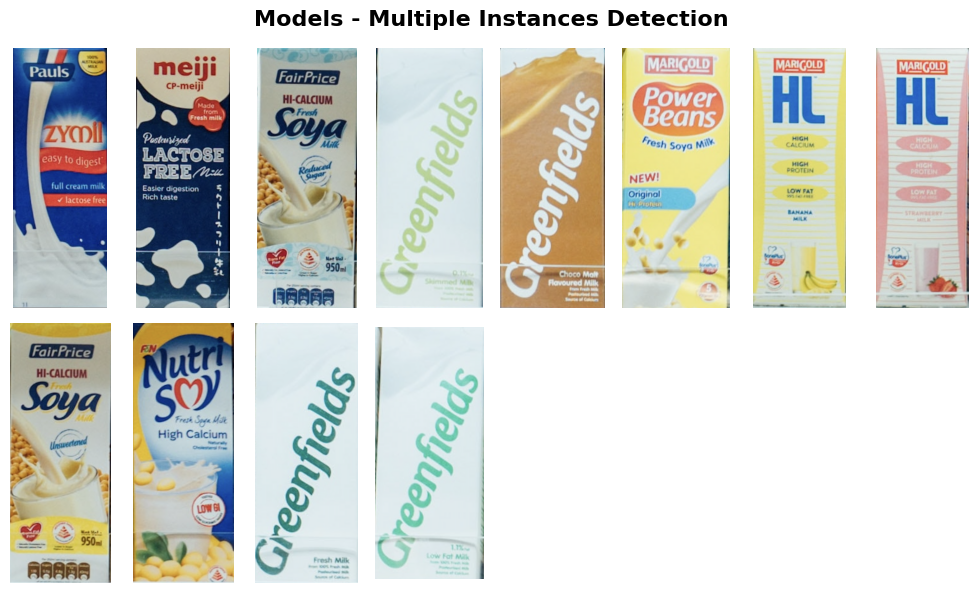

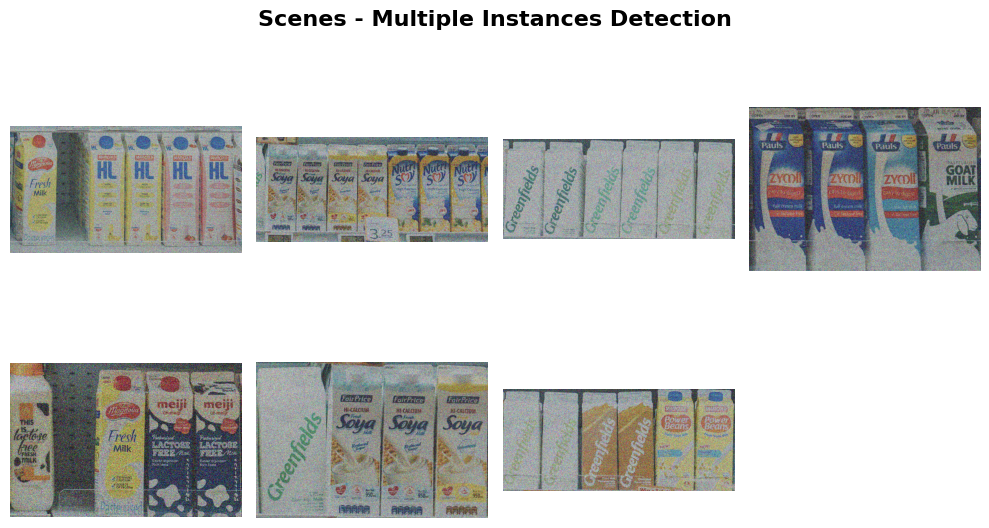

In [10]:
# {scene_idx: (model_idx, n_occurrences)}
multi_instance_real_matchings = {0: [(6,2), (7,2)], 
                                 1: [(2, 2), (8, 2), (9, 3)], 
                                 2: [(10, 2), (11, 2), (3, 2)], 
                                 3: [(0, 2)], 
                                 4: [(1, 2)], 
                                 5: [(11, 1), (2, 2), (8, 1)], 
                                 6: [(3, 2), (4, 2), (5, 2)]}

show_multiple_images(models_multiple_instances, cols=8, global_title="Models - Multiple Instances Detection")
show_multiple_images(scenes_multiple_instances, cols=4, global_title="Scenes - Multiple Instances Detection")


Multiple Detection Scenes Denoising: 100%|██████████| 7/7 [00:00<00:00,  9.38it/s]


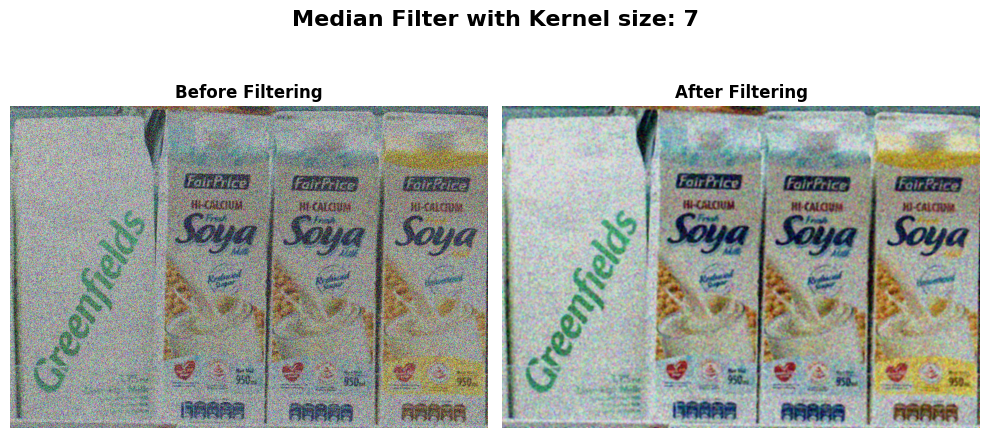

In [11]:
for scene in tqdm(scenes_multiple_instances, desc="Multiple Detection Scenes Denoising: "):
    denoised_scene = cv2.medianBlur(scene, 7)
    denoised_scenes_multiple_instances.append(denoised_scene)

# example of denoised image
random_idx = np.random.randint(len(scenes_multiple_instances))
show_multiple_images([scenes_multiple_instances[random_idx], denoised_scenes_multiple_instances[random_idx]],
                     global_title=f"Median Filter with Kernel size: {kernel_size}",
                     titles=["Before Filtering", "After Filtering"],
                     cols=2,
                     plot_height=5)

In [15]:
multi_model_scene_couples = []
multi_instance_detected_matchings = {scene: [] for scene in range(len(scenes_multiple_instances))}
min_match_count = 50

total_iterations = len(models_multiple_instances) * len(denoised_scenes_multiple_instances)
with tqdm(total=total_iterations, desc="Processing Models and Scenes") as pbar:
    for model_idx, model in enumerate(models_multiple_instances):
        for scene_idx, scene in enumerate(denoised_scenes_multiple_instances):
            
            # compute matchings, update "multi_instance_detected_matchings" and "multi_model_scene_couples"

            pbar.update(1)  # Update progress bar by one step

# After processing, summarize the detection results
print_detection_summary(multi_instance_real_matchings, multi_instance_detected_matchings)


Processing Models and Scenes: 100%|██████████| 84/84 [00:00<?, ?it/s]

Detection summary:
Scene 0              Models in the image: [(6, 2), (7, 2)]                        Models detected: []
Scene 1              Models in the image: [(2, 2), (8, 2), (9, 3)]                Models detected: []
Scene 2              Models in the image: [(10, 2), (11, 2), (3, 2)]              Models detected: []
Scene 3              Models in the image: [(0, 2)]                                Models detected: []
Scene 4              Models in the image: [(1, 2)]                                Models detected: []
Scene 5              Models in the image: [(11, 1), (2, 2), (8, 1)]               Models detected: []
Scene 6              Models in the image: [(3, 2), (4, 2), (5, 2)]                Models detected: []


In [13]:
PLOT_ALL_IMAGES = True

if PLOT_ALL_IMAGES:
    for model, scene, found, good_matches in multi_model_scene_couples:
        if found > 0:
            show_multiple_images([model, scene], cols=2, global_title=f"Found object with {good_matches} good matches")
        else:
            show_multiple_images([model, scene], cols=2, global_title=f"Object not found - {good_matches} matches found")